мини-исследование на тему связи между
некоторым словом и той или иной страной.
Предполагаемый порядок действий:
- 1) Скачать датасет с векторными представлениями слов (например, GloVe,
https://nlp.stanford.edu/projects/glove/ )
- 2) Извлечь из датасета названия стран мира и выделить их в отдельное
подмножество.
  - a. Для этого вам необходимо обучить бинарный классификатор:
    - i. Положительный класс: несколько названий стран (10-20 шт.)
    - ii. Отрицательный класс: случайные слова из датасета (1000-5000 шт.)
    - iii. Признаки – компоненты векторного представления слова
(embeddings)
  - b. Обученный классификатор применить на всем датасете, чтобы получить
больше названий стран.
  - c. Кластеризовать полученное множество и визуализировать результаты (с
помощью TSNE)

- 3) Для некоторого входного запроса (например, ‘coffee’) построить ранжированный
список стран (по близости слову из запроса). Можно использовать различные
метрики близости.
- 4) * На основе ранжированного списка отобразить результаты цветом на карте
мира: более насыщенный цвет должен быть у более близких к слову стран.

In [ ]:
!wget https://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

In [ ]:
import pandas as pd

df = pd.read_csv('glove.6B.300d.txt', sep=" ", quoting = 3, index_col=0)
df.head()

,0.04656,0.21318,-0.0074364,-0.45854,-0.035639,0.23643,-0.28836,0.21521,-0.13486,-1.6413,-0.26091,0.032434,0.056621,-0.043296,-0.021672,0.22476,-0.075129,-0.067018,-0.14247,0.038825,-0.18951,0.29977,0.39305,0.17887,-0.17343,-0.21178,0.23617,-0.063681,-0.42318,-0.11661,0.093754,0.17296,-0.33073,0.49112,-0.68995,-0.092462,0.24742,-0.17991,0.097908,0.083118,...,-0.28797,-0.058996,-0.032436,-0.0047009,-0.17052,-0.034741,-0.11489,0.075093,0.099526,0.048183,-0.073775,-0.41817,0.0041268,0.44414,-0.16062,0.14294,-2.2628,-0.027347,0.81311,0.77417,-0.25639,-0.11576,-0.11982,-0.21363,0.028429,0.27261,0.031026,0.096782,0.0067769,0.14082,-0.013064,-0.29686,-0.079913,0.195,0.031549,0.28506,-0.087461,0.0090611,-0.20989,0.053913
the,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
",",-0.255390,-0.257230,0.131690,-0.042688,0.218170,-0.022702,-0.178540,0.107560,0.058936,-1.3854,0.58509,0.036501,-0.198460,0.196130,0.409290,0.157020,-0.153050,0.050447,0.300450,-0.112950,-0.017043,0.18593,0.199820,0.200530,-0.631410,-0.126220,0.295100,-0.262820,-0.158310,0.001238,0.011784,0.587580,-0.159140,0.277310,-0.82343,-0.211340,0.013414,0.196370,-0.414700,0.001028,...,-0.063187,-0.24553,-0.059751,0.068787,-0.116270,-0.00834,0.005204,-0.201590,-0.023663,0.175620,-0.31475,-0.111620,-0.12492,0.10949,-0.26913,0.348930,-1.6997,-0.244700,0.30292,0.056720,-0.317370,0.083612,0.095949,-0.17590,0.102350,0.36808,-0.343800,0.20607,0.19135,0.109920,0.075968,-0.014359,-0.073794,0.221760,0.146520,0.566860,0.053307,-0.23290,-0.122260,0.354990
.,-0.125590,0.013630,0.103060,-0.101230,0.098128,0.136270,-0.107210,0.236970,0.328700,-1.6785,0.22393,0.124090,-0.086708,0.330100,0.343750,-0.000876,-0.296580,0.244170,-0.115920,-0.035742,-0.010830,0.20776,0.292850,-0.073491,-0.185980,-0.200900,-0.095366,0.006373,-0.136200,0.092028,-0.039957,0.190270,-0.104560,0.002767,-0.71742,-0.129150,-0.001345,0.270020,-0.053023,0.221480,...,-0.136670,-0.43962,0.237040,0.031296,0.074701,-0.22387,0.007816,-0.190160,0.044444,0.201910,-0.20814,-0.283820,0.10427,-0.21098,0.18865,0.316590,-2.0753,-0.071045,0.52419,0.056023,-0.252950,-0.062168,-0.109890,-0.35755,-0.079244,0.37472,-0.283530,0.16337,0.11165,-0.098002,0.060148,-0.156190,-0.119490,0.234450,0.081367,0.246180,-0.152420,-0.34224,-0.022394,0.136840
of,-0.076947,-0.021211,0.212710,-0.722320,-0.139880,-0.122340,-0.175210,0.121370,-0.070866,-1.5721,-0.22464,0.042690,-0.401800,0.210060,0.014288,0.416280,0.017165,0.071732,0.006925,0.181070,-0.154120,0.14933,-0.030493,0.299180,0.029479,-0.036147,-0.061125,0.083918,-0.123980,-0.100770,-0.005414,0.337100,-0.256120,0.443880,-0.68922,0.180200,0.348980,-0.052284,-0.262260,-0.471090,...,0.467280,0.48214,0.105480,0.065805,0.067221,0.13321,-0.278560,0.015532,0.300260,0.387480,-0.14401,-0.161310,0.17678,0.16448,-0.32440,0.007937,-2.2836,0.096945,0.66131,0.168570,-0.028877,-0.107910,-0.027445,-0.25695,0.046686,0.23087,-0.076458,0.27127,0.25185,0.054947,-0.366730,-0.386030,0.302900,0.015747,0.340360,0.478410,0.068617,0.18351,-0.291830,-0.046533
to,-0.257560,-0.057132,-0.671900,-0.380820,-0.364210,-0.082155,-0.010955,-0.082047,0.460560,-1.8477,-0.11258,-0.129550,0.272540,0.007289,0.260380,0.120960,-0.231930,0.032260,-0.294720,-0.675940,-0.338440,-0.23297,0.110200,0.188160,-0.451840,-0.338330,0.112740,0.494900,-0.042132,0.079961,-0.013146,0.062284,0.202230,0.038279,-1.11540,-0.121400,0.089846,0.297020,-0.055794,-0.460210,...,0.327080,-0.52049,0.037555,0.023667,-0.068237,-0.22916,0.017755,-0.183940,0.551070,-0.239650,0.39187,-0.017785,0.43113,0.27181,-0.16043,-0.347000,-2.4194,-0.028952,0.95085,0.058040,-0.236230,0.189140,0.311920,0.23064,-0.303090,-0.18603,0.076180,0.37337,-0.14444,-0.028793,-0.012806,-0.597070,0.317340,-0.252670,0.543840,0.063007,-0.049795,-0.16043,0.046744,-0.070621
and,0.038466,-0.039792,0.082747,-0.389230,-0.214310,0.170200,-0.025657,0.095780,0.238600,-1.6342,0.14332,-0.037958,-0.019583,0.384940,0.097319,0.296970,-0.345230,0.117420,-0.024189,0.160130,0.098240,

In [ ]:
emb_dict = {key: val.values for key ,val in df.T.items()}

In [ ]:
emb_dict['china']

array([-0.11286  ,  0.033802 , -0.2941   , -0.75285  ,  0.054276 ,
       -0.54167  ,  0.068019 ,  0.59827  ,  0.40707  , -2.4216   ,
        0.67319  , -0.44478  ,  0.19267  , -0.132    , -0.27979  ,
       -0.17061  , -0.087901 , -0.032694 , -0.3663   ,  0.25004  ,
       -0.18012  ,  0.18174  ,  0.17109  ,  0.20651  , -0.52343  ,
        0.2936   , -0.14797  , -0.33627  ,  0.39343  ,  0.28431  ,
        0.29872  ,  0.62853  , -0.20346  ,  0.27751  , -1.0096   ,
        0.20671  , -0.12999  , -0.85432  , -0.42196  , -0.13     ,
        0.54003  ,  0.11573  , -0.12678  ,  0.32775  , -0.10726  ,
        0.2095   , -0.1187   ,  0.24351  , -1.0391   ,  0.25945  ,
        0.36425  ,  0.25624  , -0.23305  ,  0.17933  ,  0.21582  ,
        0.82448  ,  0.20714  ,  0.11903  , -0.25287  , -0.29569  ,
       -0.27008  ,  0.65743  , -0.022714 , -0.77507  ,  0.06398  ,
       -0.032921 ,  0.17008  ,  0.80824  , -0.58816  ,  0.21539  ,
       -0.20832  ,  0.30273  , -0.0052951, -0.16262  , -0.0821

In [ ]:
import torchtext


glove = torchtext.vocab.GloVe(name='6B',dim=300)

100%|█████████▉| 399999/400000 [00:45<00:00, 8776.70it/s]


In [ ]:
country_list = [['korea'],['russia'],['russian','federation']
                ,['japan'],['spain'],['great','britain'],['england']
                ,['us'],['united','states'],['brazil'],
                ['italy'],['united','arab','emirates'],
                ['turkey'],['south','korea'],['dprk'],['south','afrika'],
                ['uae'],['central','african','republic'],['bangladesh'],['india']]

print(len(country_list))

country_dict = {}

for c in country_list:
  if len(c)==1:
    country_dict[c[0]] = glove[c[0]]
  else:
    vec  = 0
    for cc in c:
      vec+=glove[cc]
    country_dict[' '.join(c)] = vec / len(c)







20


In [ ]:
import numpy as np

exclude_list = []
for key in country_dict.keys():
  if len(key.split()) ==1:
    exclude_list.append(key)
  else:
    exclude_list.extend(key.split())
exclude_list

['korea',
 'russia',
 'russian',
 'federation',
 'japan',
 'spain',
 'great',
 'britain',
 'england',
 'us',
 'united',
 'states',
 'brazil',
 'italy',
 'united',
 'arab',
 'emirates',
 'turkey',
 'south',
 'korea',
 'dprk',
 'south',
 'afrika',
 'uae',
 'central',
 'african',
 'republic',
 'bangladesh',
 'india']

In [ ]:
dist = []

from scipy import spatial

for key in country_dict.keys():
  for key2 in country_dict.keys():
    dist.append(spatial.distance.cosine(country_dict[key],country_dict[key2]))

In [ ]:
sum(dist)/len(dist)

0.6308772820653394

In [ ]:
negative_class = {}
th = 0.6308772820653394

while len(negative_class) < 5000:
  idx = np.random.randint(0,len(glove))
  if list(glove.stoi.keys())[idx] not in exclude_list:
    emb = glove[list(glove.stoi.keys())[idx]]
    
    dist_ = []
    for key in country_dict.keys():
      dist_.append(spatial.distance.cosine(country_dict[key],emb))
    
    if sum(dist_)/len(dist_) >= th:
      negative_class[list(glove.stoi.keys())[idx]] = emb


  

In [ ]:
while len(negative_class) < 5100:
  idx = np.random.randint(0,len(glove))
  if list(glove.stoi.keys())[idx] not in exclude_list:
    emb = glove[list(glove.stoi.keys())[idx]]
    
    dist_ = []
    for key in country_dict.keys():
      dist_.append(spatial.distance.cosine(country_dict[key],emb))
    
    if th/4. <= sum(dist_)/len(dist_) <= th:
      negative_class[list(glove.stoi.keys())[idx]] = emb

KeyboardInterrupt: ignored

In [ ]:
len(negative_class)

5001

In [ ]:
!pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 4.2 MB/s 


In [ ]:
!pip install focal-loss

In [ ]:
#20 - 1
#5001 - 0
import tensorflow as tf
from tensorflow_addons.losses import SigmoidFocalCrossEntropy
from tensorflow.keras.models import  Sequential
from tensorflow.keras.layers import Dense,Input
import  tensorflow.keras.backend as K
from focal_loss import BinaryFocalLoss

def focal_loss_binary(alpha,gamma):

  def f_loss(y_true,y_pred):
    fl = SigmoidFocalCrossEntropy(alpha=alpha,gamma=gamma)
    #y_true_k = K.ones_like(y_true)
    focal_loss = fl(y_true,y_pred)
    return focal_loss
  return f_loss

class FocalLoss(tf.keras.losses.Loss):
    def __init__(self, gamma=2., alpha=4.,
                 reduction=tf.keras.losses.Reduction.AUTO, name='focal_loss'):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        Notice: y_pred is probability after softmax
        gradient is d(Fl)/d(p_t) not d(Fl)/d(x) as described in paper
        d(Fl)/d(p_t) * [p_t(1-p_t)] = d(Fl)/d(x)
        Focal Loss for Dense Object Detection
        https://arxiv.org/abs/1708.02002

        Keyword Arguments:
            gamma {float} -- (default: {2.0})
            alpha {float} -- (default: {4.0})
        """
        super(FocalLoss, self).__init__(reduction=reduction,
                                        name=name)
        self.gamma = float(gamma)
        self.alpha = float(alpha)

    def call(self, y_true, y_pred):
        """
        Arguments:
            y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
            y_pred {tensor} -- model's output, shape of [batch_size, num_cls]

        Returns:
            [tensor] -- loss.
        """
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(
            tf.subtract(1., model_out), self.gamma))
        fl = tf.multiply(self.alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)





model =  Sequential()
model.add(Input(shape=(300,)))
model.add(Dense(150, activation='relu'))
model.add(Dense(75,activation='relu'))
model.add(Dense(10,activation='relu'))
model.add(Dense(1,activation='sigmoid')) 



model.compile(optimizer='adam',metrics=['accuracy'],loss=BinaryFocalLoss(gamma=2,pos_weight=20))



In [ ]:
x_train = list(country_dict.values())
x_train.extend(list(negative_class.values()))

x_train = [x.numpy() for x in x_train]
x_train = np.array(x_train)

y_train = np.zeros(shape=(x_train.shape[0]))

y_train[0:len(country_dict)+1] = 1.

In [ ]:
y_train

array([1., 1., 1., ..., 0., 0., 0.])

In [ ]:
class_weight = {0:1, 1:20}

model.fit(x_train,y_train,epochs=7,shuffle=True,batch_size=64)

Epoch 1/7
79/79 [==============================] - 3s 5ms/step - loss: 0.0266 - accuracy: 0.9958
Epoch 2/7
79/79 [==============================] - 0s 5ms/step - loss: 0.0088 - accuracy: 0.9986
Epoch 3/7
79/79 [==============================] - 0s 5ms/step - loss: 0.0018 - accuracy: 0.9994
Epoch 4/7
79/79 [==============================] - 0s 5ms/step - loss: 5.6660e-04 - accuracy: 1.0000
Epoch 5/7
79/79 [==============================] - 0s 4ms/step - loss: 2.9551e-04 - accuracy: 1.0000
Epoch 6/7
79/79 [==============================] - 1s 12ms/step - loss: 1.7489e-04 - accuracy: 1.0000
Epoch 7/7
79/79 [==============================] - 0s 5ms/step - loss: 1.1682e-04 - accuracy: 1.0000


In [ ]:
FL = -alpha * (1-p)^gamma * log(p) 

In [ ]:
test_array = ['canada','ukraine','sweden','malta','greece','mexico','france','algeria','andorra','vatican']

x_test = []
y_test = []

for tt in test_array:
  x_test.append(glove[tt].numpy())
  y_test.append(1.)


while len(x_test) < 2500:
  idx = np.random.randint(0,len(glove))
  if list(glove.stoi.keys())[idx] not in exclude_list and list(glove.stoi.keys())[idx] not in negative_class.keys():
    emb = glove[list(glove.stoi.keys())[idx]]
    
    dist_ = []
    for key in country_dict.keys():
      dist_.append(spatial.distance.cosine(country_dict[key],emb))
    
    if sum(dist_)/len(dist_) >= th:
      x_test.append(emb.numpy())
      y_test.append(0.)

x_test = np.array(x_test)
y_test = np.array(y_test)

In [ ]:
idx_1 = y_test==1.
idx_0 = y_test==0.

y_test[idx_1] = 0.
y_test[idx_0] = 1.

In [ ]:
model.evaluate(x_test,y_test)

79/79 [==============================] - 0s 2ms/step - loss: 0.1049 - accuracy: 0.9980


[0.10486190021038055, 0.9980000257492065]

In [ ]:
from sklearn.metrics import roc_curve, f1_score
fpr, tpr,th = roc_curve(y_test,model.predict(x_test))
J = tpr-fpr
ix = np.argmax(J)
best_th = th[ix]

#score = f1_score()

print("Best threshold: {}".format(best_th))

Best threshold: 0.11136758327484131


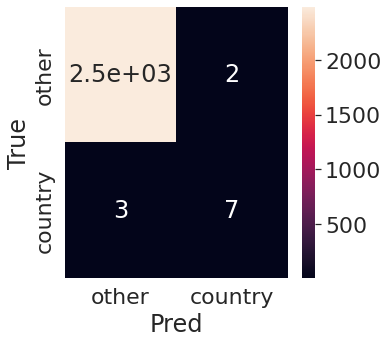

In [ ]:
%matplotlib inline
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=2)

predictions = model.predict(x_test)
predictions[predictions>=0.3] =1.
predictions[predictions<0.3] =0.

labels = ['other', 'country']
#labels = [ 'country','other']

max_test = y_test
max_pred = predictions

confusion_matrix = metrics.confusion_matrix(max_test,max_pred)

plt.figure(figsize=(5,5))

sns.heatmap(confusion_matrix,
            xticklabels=labels,
            yticklabels=labels,
            annot=True
            )
plt.ylabel('True')
plt.xlabel('Pred')
plt.show()

In [ ]:
x_test.shape

(10, 300)

In [ ]:
from tqdm import tqdm_notebook

new_country = {}
new_country_raw = {}

for key in tqdm_notebook(glove.stoi.keys()):
  if len(new_country)> 100:
    break

  if len(key)>3:
    predictions = model.predict(glove[key].numpy().reshape(1,-1))
    if predictions > 0.7:
      new_country[key] = glove[key]
      new_country_raw[key] = predictions


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/400000 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
new_data_arr = np.zeros(300)

for i,key in enumerate(glove.stoi.keys()):
  if i >= 10000:
    break
  
  new_data_arr = np.vstack([new_data_arr,glove[key].numpy()])


In [ ]:
new_data_arr.shape

(10001, 300)

In [ ]:
predictions = model.predict(new_data_arr,batch_size=1000)

In [ ]:
np.array(list(glove.stoi.keys()))[np.where(predictions>0.7)[0]]

array(['can', 'most', 'so', 'during', 'because', 'four', 'american',
       'security', 'use', 'see', '20', 'head', 'election', 'went',
       'though', 'prices', "'m", 'defense', 'move', 'august', 'process',
       'named', 'enough', 'results', 'key', '14', 'increase', '16',
       'budget', 'trading', 'opening', '`', 'effort', 'joined', 'begin',
       'daughter', 'estimated', '0', 'speaking', 'damage', 'active',
       'lived', 'telephone', 'greek', 'co', 'entered', 'seek', 'wrong',
       'argentina', 'holds', 'dispute', 'mexican', 'agree', 'aids', 'row',
       'czech', '1987', 'allows', 'animals', 'brief', 'establish',
       'discussed', 'options', 'defensive', 'laden', '1978', 'wake',
       'recalled', 'questioned', '43', 'rivers', 'creative', 'quarters',
       'hunting', 'sovereignty', 'continental', 'tactics', 'mac',
       'arrangement', 'answers', 'e.g.', 'riot', 'composition',
       'murdered', 'nn', 'reactor', 'atp', 'spell', 'hop', 'secrets',
       'bedroom', 'nova',

In [ ]:
len(new_country)

0

In [ ]:
idx_ = np.array(list(new_country_raw.values())).reshape(-1) >0.75

np.array(list(new_country.keys()))[idx_]

array(['world', 'u.s.', 'united', 'states', 'china', 'south', 'north',
       'iraq', 'countries', 'central', 'japan', 'france', 'russia',
       'russian', 'nations', 'india', 'southern', 'germany', 'iran',
       'england', 'korea', 'australia', 'africa', 'pakistan', 'britain',
       'asia', 'mexico', 'republic', 'italy', 'asian', 'spain', 'korean',
       'turkey', 'zealand', 'brazil', 'singapore', 'indonesia', 'vietnam',
       'egypt', 'thailand', 'saudi', 'poland', 'malaysia', 'sweden',
       'argentina', 'greece', 'philippines', 'netherlands', 'nigeria',
       'squad', 'zimbabwe', 'ukraine', 'lanka', 'sudan', 'kenya',
       'arabia', 'norway', 'bangladesh', 'portugal', 'kuwait', 'chile',
       'uganda', 'peru', 'fifa', 'libya', 'bulgaria', 'ethiopia',
       'indies', 'qatar', 'belarus', 'morocco', 'yemen', 'tanzania',
       'emirates'], dtype='<U11')

In [ ]:
check_split_countries = ['south','north','central','southern','republic','states']

for term in check_split_countries:
  dist_ = []
  
  for country in new_country.keys():
    dist_.append(spatial.distance.cosine(new_country[country],new_country[term]))
  
  match_country = [x for x in  np.array(list(new_country.keys()))[np.argsort(dist_)] if x not in check_split_countries]
  
  new_vector = new_country[term]
  for country in match_country[:2]:
    new_vector+= new_country[country]
  

  new_country[term+' '+country] = new_vector / len(match_country[:2])
  
  del new_country[term]



In [ ]:
new_country.keys()

dict_keys(['world', 'u.s.', 'united', 'china', 'iraq', 'countries', 'japan', 'france', 'russia', 'russian', 'nations', 'india', 'germany', 'iran', 'england', 'korea', 'australia', 'africa', 'pakistan', 'african', 'britain', 'asia', 'mexico', 'italy', 'asian', 'spain', 'korean', 'turkey', 'zealand', 'brazil', 'singapore', 'indonesia', 'send', 'vietnam', 'egypt', 'thailand', 'saudi', 'poland', 'malaysia', 'sweden', 'argentina', 'federation', 'greece', 'philippines', 'netherlands', 'nigeria', 'switzerland', 'squad', 'zimbabwe', 'ukraine', 'lanka', 'sudan', 'kenya', 'arabia', 'norway', 'bangladesh', 'portugal', 'venezuela', 'kuwait', 'denmark', 'chile', 'uganda', 'peru', 'fifa', 'libya', 'bulgaria', 'ethiopia', 'indies', 'qatar', 'belarus', 'morocco', 'yemen', 'tanzania', 'ecuador', 'emirates', 'south korea', 'north korea', 'central south korea', 'southern south korea', 'republic southern south korea', 'states u.s.'])

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(81, 300)


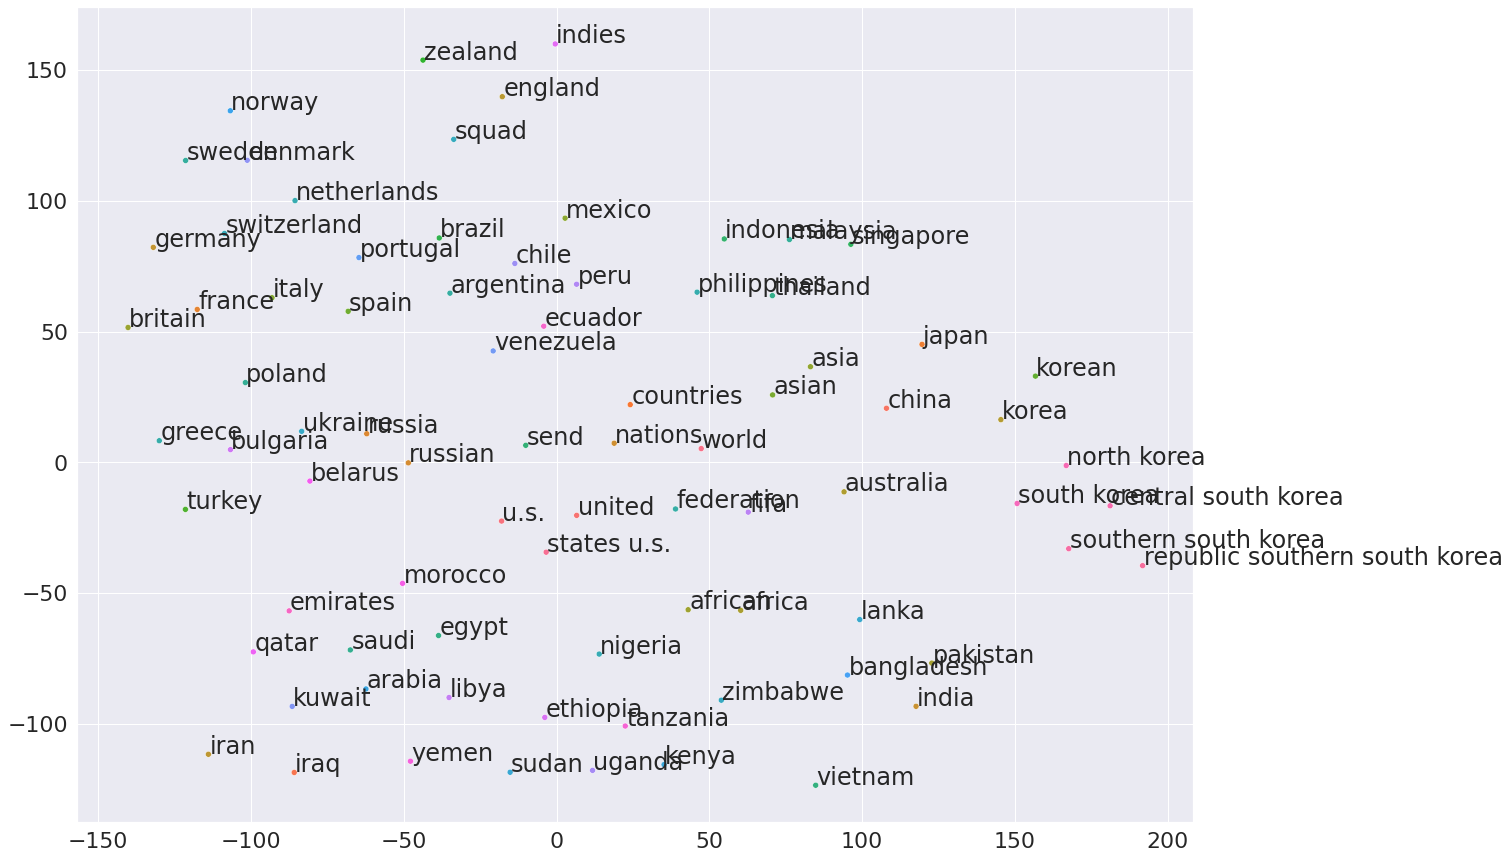

In [ ]:
#Кластеризовать полученное множество и визуализировать результаты(с помощью TSNE)
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

X = np.array([x.numpy() for x in new_country.values() ] )

emb_tsne = TSNE(n_components=2,init='random').fit_transform(X)


plt.figure(figsize=(20,15))

sns.scatterplot(x = emb_tsne[:,0], y= emb_tsne[:,1],hue = list(new_country.keys()),legend=False)

for i, key in enumerate(new_country.keys()):
  plt.text(x=emb_tsne[i,0]+0.3,y=emb_tsne[i,1]+0.3,s=key)

print(X.shape)

In [ ]:
#Для некоторого входного запроса(например, ‘coffee’) построить ранжированный списокстран (по близости слову из запроса). Можно использовать различные метрики близости

key = 'coffee'

key_vec = glove[key].numpy()

dist_ = []
  
for country in new_country.keys():
  dist_.append(spatial.distance.jaccard(new_country[country].numpy(),key_vec))

match_country =  np.array(list(new_country.keys()))[np.argsort(dist_)][:10] 

print(match_country)


['morocco' 'venezuela' 'portugal' 'bangladesh' 'norway' 'arabia' 'kenya'
 'sudan' 'lanka' 'world']


In [ ]:
#На  основе  ранжированного  списка  отобразить  результаты  цветом  на  карте мира: более насыщенный цвет должен быть у более близких к слову стран.
!wget https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/110m/cultural/ne_110m_admin_0_countries.zip
!unzip ne_110m_admin_0_countries.zip

--2021-11-29 19:45:30--  https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/110m/cultural/ne_110m_admin_0_countries.zip
Resolving www.naturalearthdata.com (www.naturalearthdata.com)... 50.87.253.14
Connecting to www.naturalearthdata.com (www.naturalearthdata.com)|50.87.253.14|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip [following]
--2021-11-29 19:45:33--  https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip
Resolving naciscdn.org (naciscdn.org)... 13.226.219.26, 13.226.219.110, 13.226.219.61, ...
Connecting to naciscdn.org (naciscdn.org)|13.226.219.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 204507 (200K) [application/zip]
Saving to: ‘ne_110m_admin_0_countries.zip’

ne_110m_admin_0_cou 100%[===================>] 199.71K   570KB/s    in 0.4s    

2021-11-29 19:45:34 (570 KB/s) - ‘ne_11

In [ ]:
!pip install geopandas

     |████████████████████████████████| 1.0 MB 4.2 MB/s 
     |████████████████████████████████| 15.4 MB 32.9 MB/s 
     |████████████████████████████████| 6.3 MB 45.1 MB/s 


In [ ]:
import geopandas as gpd

gdf = gpd.read_file('ne_110m_admin_0_countries.shp')[['SOVEREIGNT','SOV_A3','geometry']]

gdf.head()

,SOVEREIGNT,SOV_A3,geometry
0,Fiji,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,United Republic of Tanzania,TZA,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,Western Sahara,SAH,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,Canada,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,United States of America,US1,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


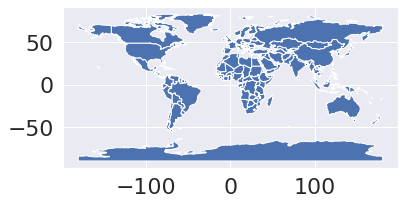

In [ ]:
gdf.plot()

In [ ]:
#gdf['country']  = list(new_country.keys())
#gdf['distance'] = dist_

#for country in new_country.keys():


new_country.keys()

dict_keys(['world', 'u.s.', 'united', 'china', 'iraq', 'countries', 'japan', 'france', 'russia', 'russian', 'nations', 'india', 'germany', 'iran', 'england', 'korea', 'australia', 'africa', 'pakistan', 'african', 'britain', 'asia', 'mexico', 'italy', 'asian', 'spain', 'korean', 'turkey', 'zealand', 'brazil', 'singapore', 'indonesia', 'send', 'vietnam', 'egypt', 'thailand', 'saudi', 'poland', 'malaysia', 'sweden', 'argentina', 'federation', 'greece', 'philippines', 'netherlands', 'nigeria', 'switzerland', 'squad', 'zimbabwe', 'ukraine', 'lanka', 'sudan', 'kenya', 'arabia', 'norway', 'bangladesh', 'portugal', 'venezuela', 'kuwait', 'denmark', 'chile', 'uganda', 'peru', 'fifa', 'libya', 'bulgaria', 'ethiopia', 'indies', 'qatar', 'belarus', 'morocco', 'yemen', 'tanzania', 'ecuador', 'emirates', 'south korea', 'north korea', 'central south korea', 'southern south korea', 'republic southern south korea', 'states u.s.'])

In [ ]:
import pandas as pd

gdf['distance'] = 0

key = 'tee'

key_vec = glove[key].numpy()
  
for country in new_country.keys():

  df = pd.DataFrame()

  for c in country.split():
    df = df.append(gdf[gdf.SOVEREIGNT.str.lower().str.contains(c)])

  if df.shape[0]==0:
    continue

  country_ = df.groupby('SOVEREIGNT').count().sort_values('SOV_A3',ascending=False).iloc[0].name 


  gdf.loc[gdf.SOVEREIGNT == country_,'distance'] = spatial.distance.cosine(new_country[country].numpy(),key_vec)

#


In [ ]:
gdf['distance'] = 1./ gdf['distance'] 

gdf['distance'] = gdf['distance'] / 1.348589
gdf[(gdf['distance']>0)&(gdf['distance']!=np.inf)].sort_values('distance')

,SOVEREIGNT,SOV_A3,geometry,distance
86,Kuwait,KWT,"POLYGON ((47.97452 29.97582, 48.18319 29.53448...",0.666439
127,Switzerland,CHE,"POLYGON ((9.59423 47.52506, 9.63293 47.34760, ...",0.675502
163,Egypt,EGY,"POLYGON ((36.86623 22.00000, 32.90000 22.00000...",0.677659
164,Libya,LBY,"POLYGON ((25.00000 22.00000, 25.00000 20.00304...",0.682681
94,Vietnam,VNM,"POLYGON ((104.33433 10.48654, 105.19991 10.889...",0.682909
...,...,...,...,...
66,Central African Republic,CAF,"POLYGON ((27.37423 5.23394, 27.04407 5.12785, ...",0.757413
29,Brazil,BRA,"POLYGON ((-53.37366 -33.76838, -53.65054 -33.2...",0.759286
148,Malaysia,MYS,"MULTIPOLYGON (((100.08576 6.46449, 100.25960 6...",0.760973
91,Thailand,THA,"POLYGON ((105.21878 14.27321, 104.28142 14.416...",0.764557


In [ ]:
gdf.loc[(gdf['distance']==np.inf),'distance'] = 0

In [ ]:
%matplotlib inline

from bokeh.io import show, output_notebook
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, ColorBar,ColorMapper, LinearColorMapper
from bokeh.palettes import brewer
import json

geodata = GeoJSONDataSource(geojson=json.dumps(json.loads(gdf.to_json())))

#color indicator
palette = brewer['YlGnBu'][8][::-1]

mapper = LinearColorMapper(palette=palette, low=0, high=1)

color_bar = ColorBar(color_mapper=mapper,orientation='horizontal')

ff = figure(title='Map density for keyword {}'.format(key),plot_height=500, plot_width=700)
ff.xgrid.grid_line_color = None
ff.ygrid.grid_line_color = None

ff.patches('xs','ys',source= geodata, fill_color= {'field':'distance','transform':mapper},line_color='black')

ff.add_layout(color_bar,'below')

output_notebook()

show(ff)

In [ ]:
#United States
(glove['united']+glove['states']) / 2.

tensor([ 4.4243e-01, -1.7406e+00,  1.4753e+00, -1.0880e+00,  8.6002e-01,
         1.9003e+00, -5.5069e+00,  2.6150e+00,  1.6768e+00, -1.2787e+01,
         5.1575e+00, -2.7072e-01, -1.1907e+00, -1.3356e+00,  1.8171e+00,
         2.1212e+00, -1.2276e+00, -2.4077e+00, -2.8708e+00, -2.9548e+00,
         2.9033e+00,  1.1320e+00,  5.1658e+00,  4.9675e+00, -3.9538e+00,
         2.4176e-01, -2.1690e-01,  9.2792e-01, -4.2545e+00,  7.6919e-01,
        -1.2052e+00,  9.9363e-01,  2.2216e+00,  6.6250e-01, -5.5538e+00,
        -1.3832e+00, -8.2266e-01, -7.2170e-01, -6.0829e+00, -6.7132e-01,
        -5.6254e+00, -2.2057e+00, -6.6416e-01,  6.6621e+00, -7.4572e-03,
        -1.1733e+00,  1.7835e+00,  1.0309e+00,  2.6947e+00,  2.9725e-01,
        -6.0991e-01, -3.4401e+00,  2.3204e+00,  2.2356e+00, -2.5235e+00,
        -1.6764e+00, -1.8278e+00,  4.1719e+00, -3.9072e-01,  2.3587e-01,
         6.8468e-01,  3.2903e+00,  2.6195e+00, -3.3906e+00,  1.0667e+00,
        -4.2626e+00,  1.0506e+00,  5.1568e+00, -4.1

In [ ]:
glove['dprk']

tensor([-0.5761,  0.0187, -0.0530, -1.0553, -0.3208, -0.3013,  0.0562, -0.3795,
        -0.1496, -1.5284,  0.3567, -0.5057,  0.4181, -0.1093, -0.5710,  0.4365,
         0.2733, -0.3572, -1.0328, -0.1857, -0.0747,  0.0798, -0.0076,  0.4521,
         0.2496,  0.5901,  0.4111,  0.0583,  0.3785, -0.1323,  0.4703, -0.0102,
         0.4451,  0.1749,  0.7548,  0.0491,  0.3492,  0.0162, -0.1257,  0.1208,
         0.0680,  0.6024, -0.1186,  0.7876, -0.8896,  0.4757,  0.1926, -0.5925,
        -0.7973,  0.8562, -0.3690,  0.2952, -0.4270, -0.1540, -0.6056,  1.1400,
         0.4036,  0.3512,  0.4362,  0.3271,  0.5995,  0.4231,  0.2491, -0.2385,
         0.2332,  0.0194,  0.6284,  0.4506, -0.2318,  0.1287, -0.0434, -0.3668,
        -0.9625, -0.0317,  0.1311,  0.1114,  0.1728,  0.5957,  0.5012, -0.1043,
        -0.5076,  0.0702,  0.1503,  0.3201,  0.3275, -0.6037, -0.4885, -0.8005,
         0.5138, -0.1549, -0.4560,  0.2437,  0.0221,  0.0028, -0.0471,  0.0969,
        -0.2148, -0.0197,  0.2053, -0.08